In [20]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

birthdays = pd.read_csv("~/Documents/birthdays.txt")
import pymc3 as pm

In [39]:
x = np.linspace(0, 10, 50)

def exp_kermal(x, y, l):
    out = [np.exp(-((m-n)**2 / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))

def brown_kernal(x, y, l):
    out = [np.exp(-(np.abs(m-n) / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))


# Draw Samples from the Prior

In [106]:
sigma = brown_kernal(x, x, 1)
mu = np.zeros(len(x))
sample = np.random.multivariate_normal(mu, sigma, size=5)
sample.shape

(5, 50)

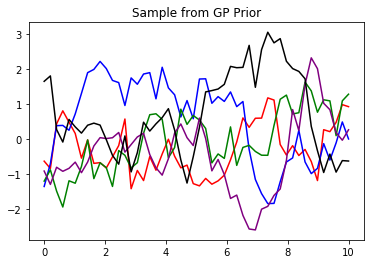

In [107]:
colors = ["red", "blue", "green", "purple", "black"]
for k, v in enumerate(colors):
    plt.plot(x, sample[k,:], color=v)
    plt.title("Sample from GP Prior")

# Fitting the GP to data

Given that $y_i \sim N(\mu, \sigma^2),\;i=1,...,n$, the GP Priors are convienent because they are conditinally conjugate so that the conditional posterior is also a Gaussian process with new $\mu$ and $\Sigma$. Given a GP Prior, $GP(0,k)$, the joint density for the observations and additional locations, $\hat{x}$ is:

$$\hat{y} \sim N(\hat{\mu}, cov(\hat{mu}))$$
where:

\begin{align*}
\hat{\mu} & = k(x, \hat{x})k(x,x)^{-1} y\\
cov(\hat{\mu}) & = k(\hat{x}, k(\hat{x}) - k(\hat{x}, x)k(x,x)^{-1}k(x,\hat{x})
\end{align*}



# Example

Given a set of points $(2,0), (4,1), (6, -1), (8,4)$ we can condition our priors using the above equations, and then take 50 samples from the multivariate normal posterior. I've defined the function "GP_cond" to accept any kernal you wish to include. Usually the choice of kernal is determined by some prior knowledge about the problem.


In [134]:
y = np.array([[2, 4, 6, 8], [0, 1, -1, 4]]).transpose()
sig = 0

def GP_cond(x, y, xhat, kernal, sig=0, l=1):
    """
    Calculates the conditional Gaussian Process. Expects x, y as column arrays
    """
    k_xx = kernal(x, x, l) + np.diag(np.zeros(len(y)) + sig)
    k_xxh = kernal(x, xhat, l)
    k_xhxh = kernal(xhat, xhat, l)
    k_xhx = kernal(xhat, x, l)

    mu = np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)), y)
    cov = k_xhxh - np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)),  k_xxh)

    return mu, cov

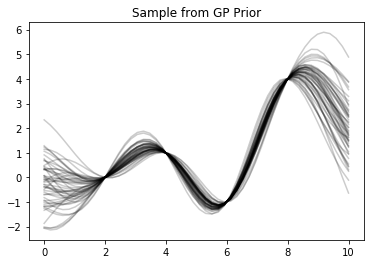

In [142]:
num_draws = 50
mu, sigma = GP_cond(y[:,0], y[:,1], x, exp_kermal, sig=0, l=2)
sample = np.random.multivariate_normal(mu, sigma, size=num_draws)

for k in range(num_draws):
    plt.plot(x, sample[k,:], color="black", alpha=.2)
    plt.title("Sample from GP Prior")